In [1]:
import requests, json

url = "https://mapprod3.environment.nsw.gov.au/arcgis/rest/services/Planning/Protection/MapServer?f=pjson"
data = requests.get(url).json()

In [2]:
# List all available layers
for layer in data["layers"]:
    print(layer["id"], layer["name"])

0 Protection
1 Acid Sulfate Soils
2 Airport Noise
3 Drinking Water Catchment
4 Groundwater Vulnerability
5 Mineral and Resource Land
6 Obstacle Limitation Surface
7 Riparian Lands and Watercourses
8 Salinity
9 Scenic Protection Land
10 Terrestrial Biodiversity
11 Wetlands
12 Environmentally Sensitive Land


In [5]:
# We keep it simple and only try to work with airport Noise. We can potentially combine different (if not all) metrics to create a wholistic view or a new index.

layer_url = "https://mapprod3.environment.nsw.gov.au/arcgis/rest/services/Planning/Protection/MapServer/2/query"
params = {
    "where": "1=1",
    "outFields": "*",
    "f": "geojson"
}

geojson_data = requests.get(layer_url, params=params).json()

In [17]:
import geopandas as gpd

gdf = gpd.GeoDataFrame.from_features(geojson_data["features"])
gdf.head(20)


,geometry,OBJECTID,EPI_NAME,LGA_NAME,PUBLISHED_DATE,COMMENCED_DATE,CURRENCY_DATE,AMENDMENT,LAY_NAME,ANEF_CODE,EPI_TYPE
0,"POLYGON ((150.82729 -32.0344, 150.82246 -32.03...",4,Upper Hunter Local Environmental Plan 2013,UPPER HUNTER,1387756800000,1387756800000,1387756800000,None,Air Noise Exposure Forecast,20 - 25,LEP
1,"POLYGON ((150.8265 -32.03468, 150.82614 -32.03...",5,Upper Hunter Local Environmental Plan 2013,UPPER HUNTER,1387756800000,1387756800000,1387756800000,None,Air Noise Exposure Forecast,25 - 30,LEP
2,"POLYGON ((150.83845 -32.04146, 150.83853 -32.0...",6,Upper Hunter Local Environmental Plan 2013,UPPER HUNTER,1387756800000,1387756800000,1387756800000,None,Air Noise Exposure Forecast,30 - 35,LEP
3,"POLYGON ((150.96671 -33.91006, 150.96657 -33.9...",7,Liverpool Local Environmental Plan 2008,LIVERPOOL,1273190400000,1273190400000,1648166400000,Amendment No 3,Australian Noise Exposure Forecast (units),20 - 25,LEP
4,"POLYGON ((150.97443 -33.9114, 150.97442 -33.91...",12,Liverpool Local Environmental Plan 2008,LIVERPOOL,1273190400000,1273190400000,1648166400000,Amendment No 3,Australian Noise Exposure Forecast (units),20 - 25,LEP
5,"POLYGON ((150.97164 -33.91058, 150.97158 -33.9...",34,Liverpool Local Environmental Plan 2008,LIVERPOOL,1273190400000,1273190400000,1648166400000,Amendment No 3,Australian Noise Exposure Forecast (units),25 - 30,LEP
6,"MULTIPOLYGON (((150.83134 -33.83833, 150.83113...",442,State Environmental Planning Policy (Precincts...,,1638403200000,1646092800000,1646092800000,None,Australian Noise Exposure Concept (units),20 - 25,SEPP
7,"POLYGON ((150.76573 -33.86091, 150.76588 -33.8...",443,State Environmental Planning Policy (Precincts...,,1638403200000,1646092800000,1646092800000,None,Australian Noise Exposure Concept (units),25 - 30,SEPP
8,"MULTIPOLYGON (((150.74601 -33.86924, 150.74614...",444,State Environmental Planning Policy (Precincts...,,1638403200000,1646092800000,1646092800000,None,Australian Noise Exposure Concept (units),30 - 35,SEPP
9,"MULTIPOLYGON (((150.73684 -33.8728, 150.73713 ...",445,State Environmental Planning Policy (Precincts...,,1638403200000,1646092800000,1646092800000,None,Australian Noise Exposure Concept (units),35 - 40,SEPP


In [7]:

# We just want to see which columns have useful info like noise level.

print("Columns in dataset:")
print(gdf.columns)


Columns in dataset:
Index(['geometry', 'OBJECTID', 'EPI_NAME', 'LGA_NAME', 'PUBLISHED_DATE',
       'COMMENCED_DATE', 'CURRENCY_DATE', 'AMENDMENT', 'LAY_NAME', 'ANEF_CODE',
       'EPI_TYPE'],
      dtype='object')


In [11]:
import numpy as np
import pandas as pd

# Replace 'Low Noise' with 0 and extract the lower bound of the range for other values
gdf['NoiseLevel'] = gdf['ANEF_CODE'].replace('Low Noise', '0 - 0').str.split(' - ', expand=True)[0]

# Convert to numeric, coercing errors to NaN, and fill NaN with 0
gdf['NoiseLevel'] = pd.to_numeric(gdf['NoiseLevel'], errors='coerce').fillna(0)

# Compute a simple 0–100 score (100 = quietest)
gdf['Noise_Exposure_Score'] = 100 - (
    (gdf['NoiseLevel'] - gdf['NoiseLevel'].min())
    / (gdf['NoiseLevel'].max() - gdf['NoiseLevel'].min())
) * 100

# Preview
gdf[['LGA_NAME', 'ANEF_CODE', 'Noise_Exposure_Score']].head()

,LGA_NAME,ANEF_CODE,Noise_Exposure_Score
0,UPPER HUNTER,20 - 25,42.857143
1,UPPER HUNTER,25 - 30,28.571429
2,UPPER HUNTER,30 - 35,14.285714
3,LIVERPOOL,20 - 25,42.857143
4,LIVERPOOL,20 - 25,42.857143


In [13]:

# We'll find the average Noise Exposure Score per local government area (LGA)
# so we can compare which suburbs or councils are quieter overall.

lga_summary = (
    gdf.groupby("LGA_NAME", dropna=False)["Noise_Exposure_Score"]
    .mean()
    .reset_index()
    .sort_values("Noise_Exposure_Score", ascending=False)
)

lga_summary.head()


,LGA_NAME,Noise_Exposure_Score
3,MID-COAST,100.000000
1,CESSNOCK,37.142857
2,LIVERPOOL,32.380952
4,UPPER HUNTER,28.571429
0,,21.428571


/tmp/ipython-input-4220418749.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


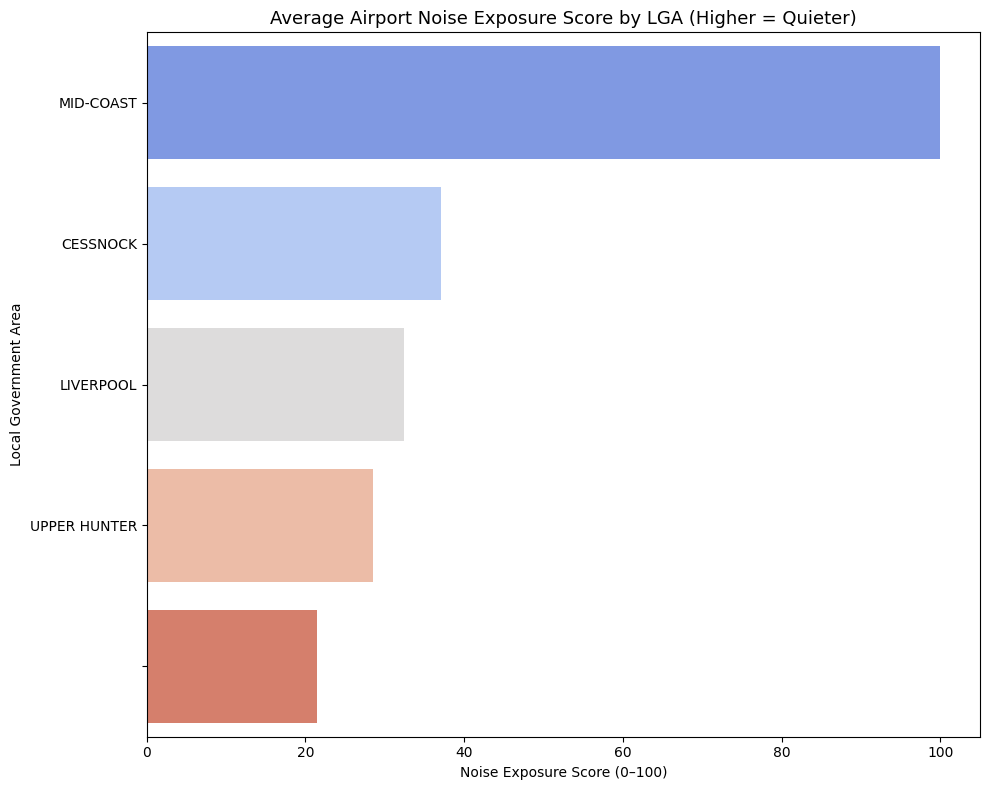

In [14]:
# Blue = quieter (higher score), Red = noisier (lower score)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.barplot(
    data=lga_summary,
    y="LGA_NAME",
    x="Noise_Exposure_Score",
    palette="coolwarm"
)
plt.title("Average Airport Noise Exposure Score by LGA (Higher = Quieter)", fontsize=13)
plt.xlabel("Noise Exposure Score (0–100)")
plt.ylabel("Local Government Area")
plt.tight_layout()
plt.show()

In [15]:
# This gives an investor-friendly list: which LGAs have the lowest airport noise.

quietest = gdf.groupby('LGA_NAME')['Noise_Exposure_Score'].mean().sort_values(ascending=False)
print("Top 10 Quietest LGAs near airports:")
print(quietest.head(10))


Top 10 Quietest LGAs near airports:
LGA_NAME
MID-COAST       100.000000
CESSNOCK         37.142857
LIVERPOOL        32.380952
UPPER HUNTER     28.571429
                 21.428571
Name: Noise_Exposure_Score, dtype: float64


In [16]:
# Cannot understand why there are only 4 LGAS but very short on time. Maybe servers cap results?

print("Unique LGAs in the dataset:")
print(gdf['LGA_NAME'].unique())
print("\nNumber of unique LGAs:")
print(gdf['LGA_NAME'].nunique())

Unique LGAs in the dataset:
['UPPER HUNTER' 'LIVERPOOL' '' 'MID-COAST' 'CESSNOCK']

Number of unique LGAs:
5
